In [1]:
import sys
sys.path.append("../")

import torch
from models.RDPG_GD_Unroll_shared_restricted import GD_Unroll
from models.RDPG_GD import RDPG_GD_Armijo
from torch_geometric.utils import to_dense_adj, stochastic_blockmodel_graph
import matplotlib.pyplot as plt
import seaborn as sns

# LASE Model

The model consists of concatenatig $k$ layers of LASE Block.

**LASE Block**

$X^{k+1}\rightarrow X^kW_0 + AX^kW_1 + X^kW_3(X^kW_4)^TX^kW_2$

## Test 1

- Training set consisted of multiple realizations of SBM-2 with different symetric distributions; num_nodes = 500
- Embedding dimension: d = 2
- Layers: k = 20
- Model parameters: 
    - Shared weights 
    - With restrictions over $W_2$, $W_3$ and $W_4$ ($W_2$ and $W_3$ diagonal matrixes; $W_4$ nule)
    - Fixed $W_0$, $W_3$ and $W_4$ 


In [40]:
in_channels = 2
out_channels = 2
gd_steps = 5
device = 'cpu'

lase = GD_Unroll(in_channels, out_channels, gd_steps)
lase.load_state_dict(torch.load('../saved_models/ugd_sim_ini_fix_d2.pt'))
lase.to(device)
lase.eval()

GD_Unroll(
  (gd): GD_Block(
    (gcn): TAGConv(2, 2, K=1)
    (gat): Transformer_Block()
  )
)

Inference increasing number of nodes and decreasing number of layers to 5.

Loss RDPG GD Armijo:  tensor(399.5791)
Armijo iterations:  17
Loss LASE shared weights (5 layers):  tensor(404.7895)


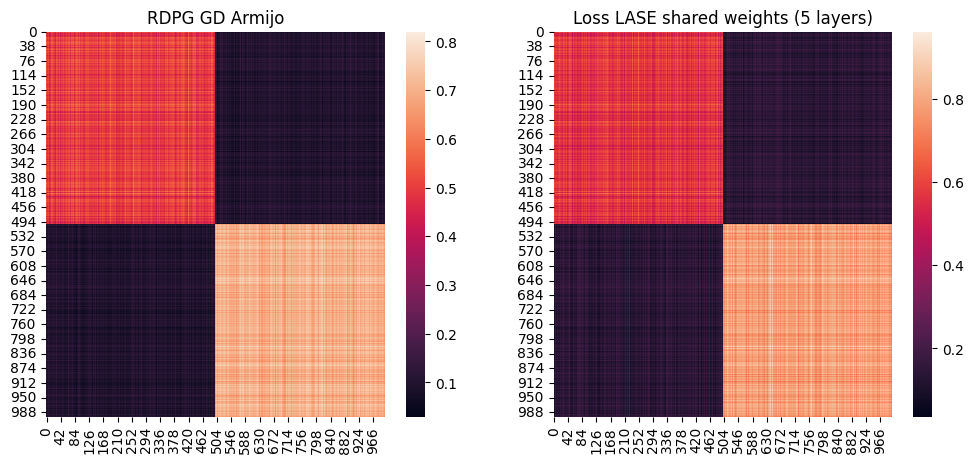

In [46]:
num_nodes = 1000
d = 2
n = [int(num_nodes/2), int(num_nodes/2)]

p = [[0.5, 0.1], 
     [0.1, 0.7]]

edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous()
x = torch.rand(num_nodes,d).to(device)


x_gd, cost_gd, iter = RDPG_GD_Armijo(x.squeeze(0), edge_index)
x_gd = x_gd.to(device)
loss = torch.norm((x_gd@x_gd.T - to_dense_adj(edge_index).squeeze(0)))
print("Loss RDPG GD Armijo: ", loss)
print("Armijo iterations: ", iter)

x_lase = lase(x, edge_index, edge_index_2)
x_lase = x_lase.detach()
loss = torch.norm((x_lase@x_lase.T - to_dense_adj(edge_index).squeeze(0)))
print(f"Loss LASE shared weights ({gd_steps} layers): ", loss)
x_lase = x_lase.to('cpu')

fig, axes = plt.subplots(1, 2, figsize =(12,5))
axes[0].set_title('RDPG GD Armijo')
sns.heatmap(x_gd@x_gd.T, ax=axes[0])
axes[1].set_title(f'Loss LASE shared weights ({gd_steps} layers)')
sns.heatmap(x_lase@x_lase.T, ax=axes[1])
plt.show()

In [47]:
%timeit -n 10 -r 10 RDPG_GD_Armijo(x.squeeze(0), edge_index)

37.4 ms ± 233 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [48]:
%timeit -n 10 -r 10 lase(x, edge_index, edge_index_2)

87.2 ms ± 3.09 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


Loss RDPG GD Armijo:  tensor(478.8757)
Armijo iterations:  15
Loss LASE shared weights (5 layers):  tensor(501.7999)


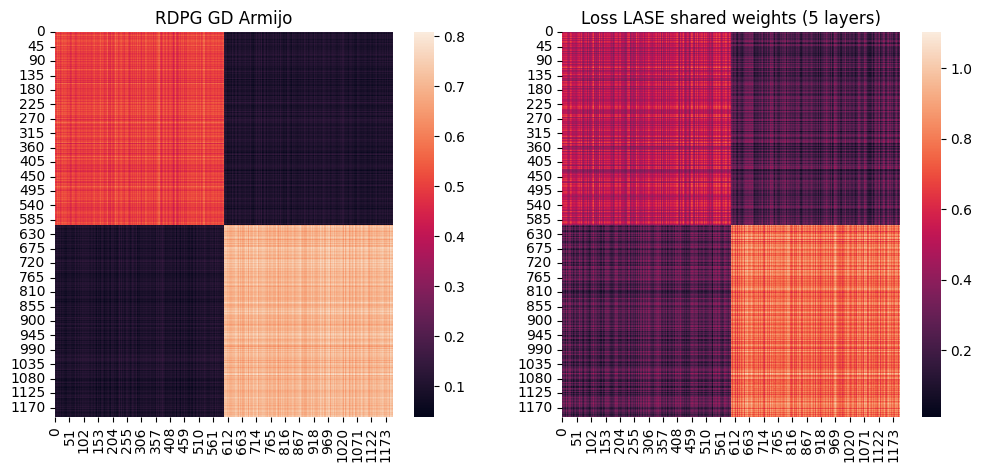

In [49]:
num_nodes = 1200
d = 2
n = [int(num_nodes/2), int(num_nodes/2)]

p = [[0.5, 0.1], 
     [0.1, 0.7]]

edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous()
x = torch.rand(num_nodes,d).to(device)


x_gd, cost_gd, iter = RDPG_GD_Armijo(x.squeeze(0), edge_index)
x_gd = x_gd.to(device)
loss = torch.norm((x_gd@x_gd.T - to_dense_adj(edge_index).squeeze(0)))
print("Loss RDPG GD Armijo: ", loss)
print("Armijo iterations: ", iter)

x_lase = lase(x, edge_index, edge_index_2)
x_lase = x_lase.detach()
loss = torch.norm((x_lase@x_lase.T - to_dense_adj(edge_index).squeeze(0)))
print(f"Loss LASE shared weights ({gd_steps} layers): ", loss)
x_lase = x_lase.to('cpu')

fig, axes = plt.subplots(1, 2, figsize =(12,5))
axes[0].set_title('RDPG GD Armijo')
sns.heatmap(x_gd@x_gd.T, ax=axes[0])
axes[1].set_title(f'Loss LASE shared weights ({gd_steps} layers)')
sns.heatmap(x_lase@x_lase.T, ax=axes[1])
plt.show()

Loss RDPG GD Armijo:  tensor(599.0956)
Armijo iterations:  10000
Loss LASE shared weights (5 layers):  tensor(inf)


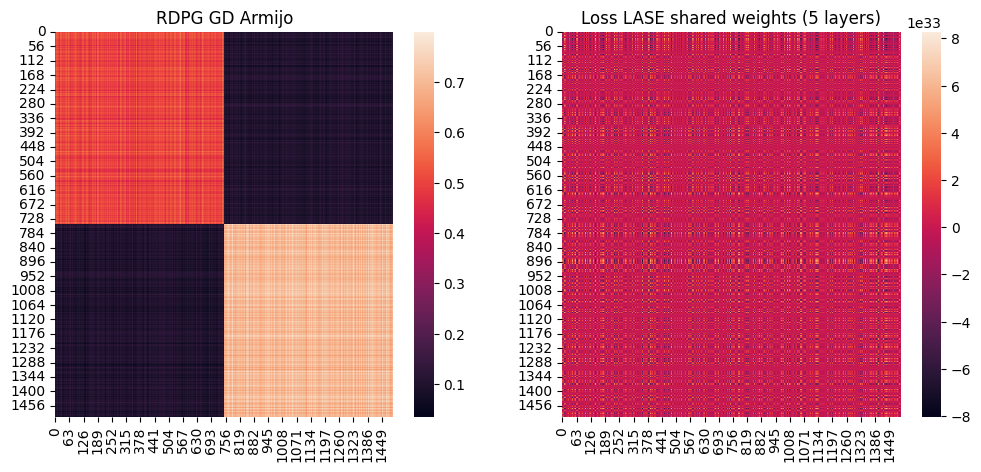

In [50]:
num_nodes = 1500
d = 2
n = [int(num_nodes/2), int(num_nodes/2)]

p = [[0.5, 0.1], 
     [0.1, 0.7]]

edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous()
x = torch.rand(num_nodes,d).to(device)


x_gd, cost_gd, iter = RDPG_GD_Armijo(x.squeeze(0), edge_index)
x_gd = x_gd.to(device)
loss = torch.norm((x_gd@x_gd.T - to_dense_adj(edge_index).squeeze(0)))
print("Loss RDPG GD Armijo: ", loss)
print("Armijo iterations: ", iter)

x_lase = lase(x, edge_index, edge_index_2)
x_lase = x_lase.detach()
loss = torch.norm((x_lase@x_lase.T - to_dense_adj(edge_index).squeeze(0)))
print(f"Loss LASE shared weights ({gd_steps} layers): ", loss)
x_lase = x_lase.to('cpu')

fig, axes = plt.subplots(1, 2, figsize =(12,5))
axes[0].set_title('RDPG GD Armijo')
sns.heatmap(x_gd@x_gd.T, ax=axes[0])
axes[1].set_title(f'Loss LASE shared weights ({gd_steps} layers)')
sns.heatmap(x_lase@x_lase.T, ax=axes[1])
plt.show()

In [53]:
in_channels = 2
out_channels = 2
gd_steps = 20
device = 'cpu'

lase = GD_Unroll(in_channels, out_channels, gd_steps)
lase.load_state_dict(torch.load('../saved_models/ugd_sim_ini_fix_d2.pt'))
lase.to(device)
lase.eval()

GD_Unroll(
  (gd): GD_Block(
    (gcn): TAGConv(2, 2, K=1)
    (gat): Transformer_Block()
  )
)

Loss RDPG GD Armijo:  tensor(599.1014)
Armijo iterations:  15


Loss LASE shared weights (20 layers):  tensor(nan)


/home/sofia/lase/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/sofia/lase/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


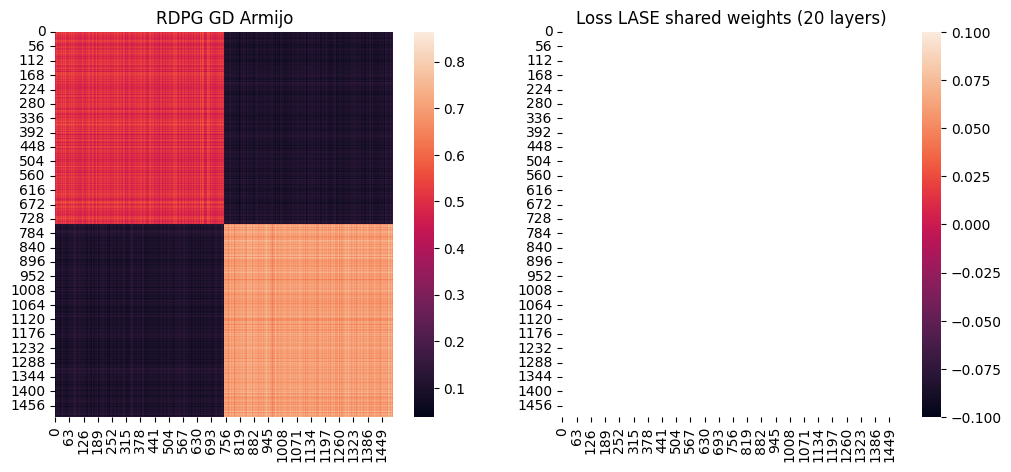

In [56]:
num_nodes = 1500
d = 2
n = [int(num_nodes/2), int(num_nodes/2)]

p = [[0.5, 0.1], 
     [0.1, 0.7]]

edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous()
x = torch.rand(num_nodes,d).to(device)


x_gd, cost_gd, iter = RDPG_GD_Armijo(x.squeeze(0), edge_index)
x_gd = x_gd.to(device)
loss = torch.norm((x_gd@x_gd.T - to_dense_adj(edge_index).squeeze(0)))
print("Loss RDPG GD Armijo: ", loss)
print("Armijo iterations: ", iter)

x_lase = lase(x, edge_index, edge_index_2)
x_lase = x_lase.detach()
loss = torch.norm((x_lase@x_lase.T - to_dense_adj(edge_index).squeeze(0)))
print(f"Loss LASE shared weights ({gd_steps} layers): ", loss)
x_lase = x_lase.to('cpu')

fig, axes = plt.subplots(1, 2, figsize =(12,5))
axes[0].set_title('RDPG GD Armijo')
sns.heatmap(x_gd@x_gd.T, ax=axes[0])
axes[1].set_title(f'Loss LASE shared weights ({gd_steps} layers)')
sns.heatmap(x_lase@x_lase.T, ax=axes[1])
plt.show()